In [2]:
%matplotlib inline
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import tensorflow as tf

from skimage import feature
from skimage import io
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy.ndimage.filters import gaussian_filter

In [90]:
def edge_detect(img):
    return roberts(img)

def gauss_filter(img, sigma=4):
    return gaussian_filter(img, sigma=sigma)

def invert(img):
    return img - 255

In [136]:
def load_prep_img(path,sig=2):
    img = io.imread(path)
    oimg = img
    if len(img.shape) == 3:
        img = img[:,:,2]
    img = edge_detect(img)
    img = np.stack([img,img,img], axis=2)
    img = gauss_filter(img,sigma=sig)
    return img,oimg
    
    

In [149]:
def next_batch(batch_size,sig=2):
    pos_images = []
    proc_images = []
    orig_images = []
    if sig == 'rand':
        sig = np.random.randint(0,4)
    
    for _,_,files in os.walk('./images/'):
        for f in files:
            pos_images.append('./images/'+f)
    num_images = len(pos_images)
    random.shuffle(pos_images)
    for i in range(batch_size):
        x,y = load_prep_img(pos_images[i])
        proc_images.append(x)
        orig_images.append(y)
    return np.array(proc_images),np.array(orig_images)


(177, 284, 3) (177, 284, 3)


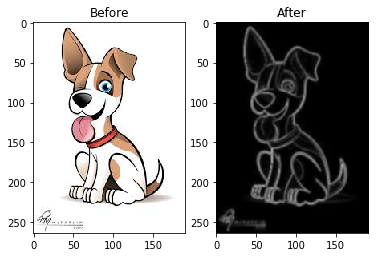

In [162]:
max_width = 400
max_height = 600

# sample data
img,oimg = load_prep_img('./images/50.jpg',sig=np.random.randint(0,4))
fig = plt.figure()
a=fig.add_subplot(1,2,1)
plt.imshow(oimg)
a.set_title('Before')
a=fig.add_subplot(1,2,2)
plt.imshow(img)
a.set_title('After')

In [ ]:
# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 100

display_step = 1000
examples_to_show = 10

In [155]:
# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 240000 # MNIST data input (img shape: 400*600)

In [206]:
X = tf.placeholder("float", [None, 400,600,3])
Y = tf.placeholder("float", [None, 400,600,3])

In [163]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, max_width,max_height,3])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([max_width,max_height,3])),
}

In [197]:
#Building decoder (need to add deconv)
def encoder(x, mode=False):
    # convalution
    # input shape [batch_size,400,600,3]
    # output shape [batch_size, 400, 600, 32]
    conv1 = tf.layers.conv2d(
      inputs=x,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    # input shape [batch_size, 400, 600, 32]
    # output shape [batch_size, 200, 300, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # input shape [batch_size, 200, 300, 32]
    # output shape [batch_size, 200, 300, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    # input shape [batch_size, 200, 300, 64]
    # output shape [batch_size, 100, 150, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # input shape [batch_size, 100, 150, 64]
    # output shape [batch_size, 100, 150, 128]
    conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    # input shape [batch_size, 100, 150, 128]
    # output shape [batch_size, 50, 75, 128]
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    
    pool3_flat = tf.reshape(pool3, [-1, 50 * 75 * 128])
    
    dense = tf.layers.dense(inputs=pool3_flat, units=50*75*128, activation=tf.nn.relu)
    
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode)
    # Decoder Hidden layer with sigmoid activation #1
    #layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder_h1']),
    #                               biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
    #                               biases['decoder_b2']))
    return dropout

In [201]:
# Building the encoder (need to add conv)
def decoder(x, mode=False):
    
    dense = tf.layers.dense(inputs=x, units=50*75*128, activation=tf.nn.relu)
    dense = tf.layers.dense(inputs=dense, units=50 * 75 * 128, activation=tf.nn.relu)
    dense = tf.layers.dense(inputs=dense, units=100 * 150 * 64, activation=tf.nn.relu)
    dense = tf.layers.dense(inputs=dense, units=200 * 300 * 32, activation=tf.nn.relu)
    dense = tf.layers.dense(inputs=dense, units=400* 600 * 3, activation=tf.nn.relu)
    
    return dense

In [202]:
encoder_op

<tf.Tensor 'dropout_7/dropout/mul:0' shape=(?, 480000) dtype=float32>

In [207]:
# Construct model
encoder_op = encoder(X, mode=True)
decoder_op = decoder(encoder_op, mode=True)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = tf.reshape(Y,[1,400*600*3])

In [208]:
# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

In [209]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [ ]:
# Start Training
# Start a new TF session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        x,y = next_batch(batch_size)

        # Run optimization op (backprop) and cost op (to get loss value)
        _, l = sess.run([optimizer, loss], feed_dict={X: x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))